In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations
import plotly.express as px
from itertools import product
import time
import numpy as np

# Save Results

## Load mlflow runs

In [207]:
db_port = 5003
db_name = 'recursive_clustering'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://belucci@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [208]:
experiment_names

['Default',
 'blob_experiment',
 'hpo_classif_experiment',
 'hpo_openml_experiment',
 'hpo_gaussian_experiment',
 'hpo_openml_final',
 'outlier_hc',
 'time_hc']

In [209]:
experiments_names = [
    'blob_experiment',
]

In [210]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_cores',
    'n_jobs',
    'model_params/representative_method',
    'seed_dataset',
]

In [211]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used'
]

In [212]:
tags_columns = [
    'raised_exception',
    'EXCEPTION'
]

In [213]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [214]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [215]:
df_runs_raw

key,status,start_time,end_time,model_nickname,model_params/representative_method,n_cores,n_features,n_jobs,n_samples,seed_dataset,fit_model_return_elapsed_time,max_memory_used,EXCEPTION,raised_exception
run_uuid,,,,,,,,,,,,,,
00069f9700f1440a9dd1c3e85a51c153,FINISHED,1732899429970,1.732899e+12,RecursiveClustering,NaN,1,14427,1,100,0,0.108414,278.552,NaN,False
002ae3bc028c4dd6be9a023079ad331e,FINISHED,1738204074106,1.738204e+12,RecursiveClustering,closest_overall_1000,4,14427,4,347,0,0.348808,348.192,NaN,False
00554ba1404b47b489b3a115188a20e3,RUNNING,1738251002151,NaN,WardAgglomerativeClustering,NaN,4,14427,NaN,14427,3,NaN,NaN,NaN,NaN
006d6f6e42a046d9aa1036b72d4c956b,FINISHED,1738254131466,1.738254e+12,HDBSCAN,NaN,4,1202,4,14427,4,225.304374,543.728,NaN,False
00855d71613747f4aaab34ff2a216354,FINISHED,1738250378524,1.738250e+12,RecursiveClustering,NaN,4,14427,4,347,1,2.199081,347.992,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffa6616a8f40469985fa3e01985d0b9f,RUNNING,1733324309627,NaN,CompleteAgglomerativeClustering,NaN,4,14427,NaN,14427,0,NaN,NaN,NaN,NaN
ffb49cd02bf84f6e9ea02faaccf8b08f,FINISHED,1732899554272,1.732900e+12,RecursiveClustering,NaN,1,50000,1,14427,0,17.187922,11611.328,NaN,False
ffcd7958d9234c729e0727716e1247e8,FINISHED,1732899454862,1.732899e+12,RecursiveClustering,NaN,1,4163,1,4163,0,1.280236,1224.972,NaN,False


In [216]:
# Separate our method with two types of representative_method
df_runs = df_runs_raw.copy()
df_runs.loc[(df_runs['model_nickname'] == 'RecursiveClustering') & (df_runs['model_params/representative_method'].isna()), 'model_params/representative_method'] = 'closest_overall'
df_runs.loc[(df_runs['model_nickname'] == 'RecursiveClustering') & (df_runs['model_params/representative_method'] == 'closest_overall_1000'), 'model_nickname'] = df_runs.loc[(df_runs['model_nickname'] == 'RecursiveClustering') & (df_runs['model_params/representative_method'] == 'closest_overall_1000'), 'model_nickname'] + '_aproximated'


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [217]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'seed_dataset',
]
df_runs = df_runs.dropna(axis=0, how='all', subset=['fit_model_return_elapsed_time']).copy()
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

In [218]:
no_run_time = np.inf
df_runs_timed_out = df_runs_raw.copy()
df_runs_timed_out = df_runs_timed_out.loc[df_runs_timed_out.EXCEPTION == 'FunctionTimedOut']
df_runs_timed_out = df_runs_timed_out.loc[(~df_runs_timed_out.duplicated(non_duplicate_columns))]
df_runs_timed_out['fit_model_return_elapsed_time'] = no_run_time
df_runs = pd.concat([df_runs, df_runs_timed_out])

In [219]:
status = 'FAILED'
no_run_memory = np.inf
raised_exception = True
EXCEPTION = 'NoRun'
start_time = time.time() * 1000
end_time = time.time() * 1000

In [220]:
# IRFLLRR do not run with n_samples > 14427
model_nickname = 'IRFLLRR'
n_samples = ['14427', '50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
seeds_datasets = [str(i) for i in range(10)]
combinations = product(n_samples, n_features, seeds_datasets)
df_cat = []
indexes = []
for n_sample, n_feature, seed in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['seed_dataset'] = seed
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [221]:
# KMeansProj do not run with (14427,14427), (14427,50000), (50000,14427), (50000,50000)
model_nickname = 'KMeansProj'
n_samples = ['14427', '50000']
n_features = ['14427', '50000']
seeds_datasets = [str(i) for i in range(10)]
combinations = product(n_samples, n_features, seeds_datasets)
df_cat = []
indexes = []
for n_sample, n_feature, seed in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['seed_dataset'] = seed
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [222]:
# HDBSCAN do not run with (14427,14427), (14427,50000), and n_samples = 50000 n_features > 347
model_nickname = 'HDBSCAN'
n_samples = ['50000']
n_features = ['347', '1202', '4163', '14427', '50000']
seeds_datasets = [str(i) for i in range(10)]
combinations = list(product(n_samples, n_features, seeds_datasets))
combinations_samples_features = [('14427', '14427'), ('14427', '50000')]
for samples, features in combinations_samples_features:
    combinations += list(product([samples], [features], seeds_datasets))
df_cat = []
indexes = []
for n_sample, n_feature, seed in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['seed_dataset'] = seed
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [223]:
# SpectralSubspaceRandomization do not run with n_samples > 50000
model_nickname = 'SpectralSubspaceRandomization'
n_samples = ['50000']
n_features = ['100', '347', '1202', '4163', '14427', '50000']
seeds_datasets = [str(i) for i in range(10)]
combinations = list(product(n_samples, n_features, seeds_datasets))
df_cat = []
indexes = []
for n_sample, n_feature, seed in combinations:
    df = {}
    index = f'{model_nickname}_{n_sample}_{n_feature}'
    df['status'] = status
    df['start_time'] = start_time
    df['end_time'] = end_time
    df['model_nickname'] = model_nickname
    df['n_features'] = n_feature
    df['n_samples'] = n_sample
    df['seed_dataset'] = seed
    df['fit_model_return_elapsed_time'] = no_run_time
    df['max_memory_used'] = no_run_memory
    df['EXCEPTION'] = EXCEPTION
    df['raised_exception'] = raised_exception
    df_cat.append(df)
    indexes.append(index)
df_no_run = pd.DataFrame(df_cat, index=indexes)
df_runs = pd.concat([df_runs, df_no_run])

In [224]:
# ensure no duplicates
df_runs = df_runs.loc[(~df_runs.duplicated(non_duplicate_columns))]

# Missing

In [225]:
df_runs

,status,start_time,end_time,model_nickname,model_params/representative_method,n_cores,n_features,n_jobs,n_samples,seed_dataset,fit_model_return_elapsed_time,max_memory_used,EXCEPTION,raised_exception
00069f9700f1440a9dd1c3e85a51c153,FINISHED,1.732899e+12,1.732899e+12,RecursiveClustering,closest_overall,1,14427,1,100,0,0.108414,278.552,NaN,False
002ae3bc028c4dd6be9a023079ad331e,FINISHED,1.738204e+12,1.738204e+12,RecursiveClustering_aproximated,closest_overall_1000,4,14427,4,347,0,0.348808,348.192,NaN,False
006d6f6e42a046d9aa1036b72d4c956b,FINISHED,1.738254e+12,1.738254e+12,HDBSCAN,NaN,4,1202,4,14427,4,225.304374,543.728,NaN,False
00855d71613747f4aaab34ff2a216354,FINISHED,1.738250e+12,1.738250e+12,RecursiveClustering,closest_overall,4,14427,4,347,1,2.199081,347.992,NaN,False
009060d102de4ee2b02fabfd9b962a68,FINISHED,1.738252e+12,1.738252e+12,SpectralSubspaceRandomization,NaN,4,14427,NaN,100,1,1.183900,295.056,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SpectralSubspaceRandomization_50000_50000,FAILED,1.738255e+12,1.738255e+12,SpectralSubspaceRandomization,NaN,NaN,50000,NaN,50000,5,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_50000,FAILED,1.738255e+12,1.738255e+12,SpectralSubspaceRandomization,NaN,NaN,50000,NaN,50000,6,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_50000,FAILED,1.738255e+12,1.738255e+12,SpectralSubspaceRandomization,NaN,NaN,50000,NaN,50000,7,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_50000,FAILED,1.738255e+12,1.738255e+12,SpectralSubspaceRandomization,NaN,NaN,50000,NaN,50000,8,inf,inf,NoRun,True


In [226]:
df_runs['model_nickname'].unique().tolist()

['RecursiveClustering',
 'RecursiveClustering_aproximated',
 'HDBSCAN',
 'SpectralSubspaceRandomization',
 'AffinityPropagation',
 'KMeans',
 'OPTICS',
 'Clique',
 'WardAgglomerativeClustering',
 'SpectralClustering',
 'MeanShift',
 'SingleAgglomerativeClustering',
 'IRFLLRR',
 'CompleteAgglomerativeClustering',
 'KMeansProj',
 'Proclus',
 'DBSCAN',
 'AverageAgglomerativeClustering']

In [227]:
non_duplicate_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'seed_dataset',
]

In [228]:
n_features = ['14427']
n_samples = ['100', '347', '1202', '4163', '14427', '50000']
seeds_datasets = [str(i) for i in range(5)]
model_nickname = [
    # 'RecursiveClustering',
    # 'RecursiveClustering_aproximated',
    # 'KMeans',
    # 'AffinityPropagation',
    # 'Clique',
    # 'SpectralClustering',
    # 'MeanShift',
    # 'SingleAgglomerativeClustering',
    # 'IRFLLRR',
    # 'CompleteAgglomerativeClustering',
    # 'KMeansProj',
    # 'HDBSCAN',
    # 'Proclus',
    # 'OPTICS',
    # 'SpectralSubspaceRandomization',
    # 'AverageAgglomerativeClustering',
    'DBSCAN',
    # 'WardAgglomerativeClustering'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, n_samples, n_features, seeds_datasets]
df_missing = get_missing_entries(df_runs, columns_names, should_contain_values)

In [229]:
df_missing

,model_nickname,n_samples,n_features,seed_dataset


In [230]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

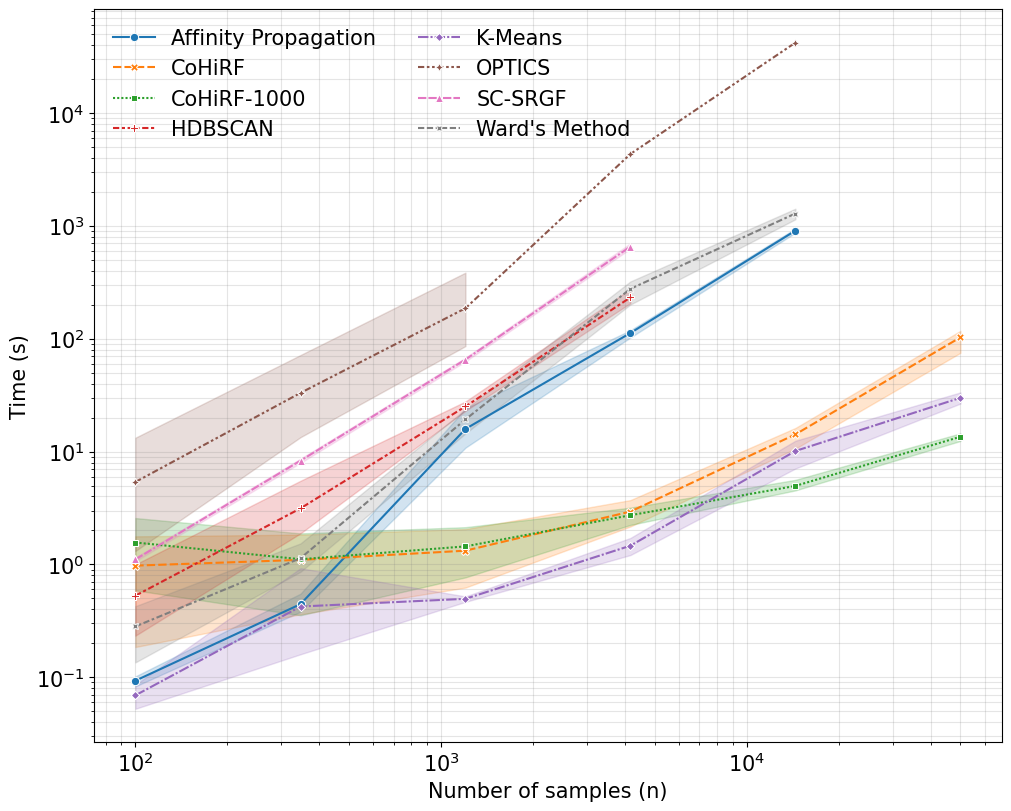

In [255]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['model_nickname'].isin(['RecursiveClustering','RecursiveClustering_aproximated', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True, 
    'savefig.bbox': 'tight', 
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    # df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of samples (n)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.0), ncols=2)
    plt.savefig(f'time_n-samples_n-features{n_features}_2.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

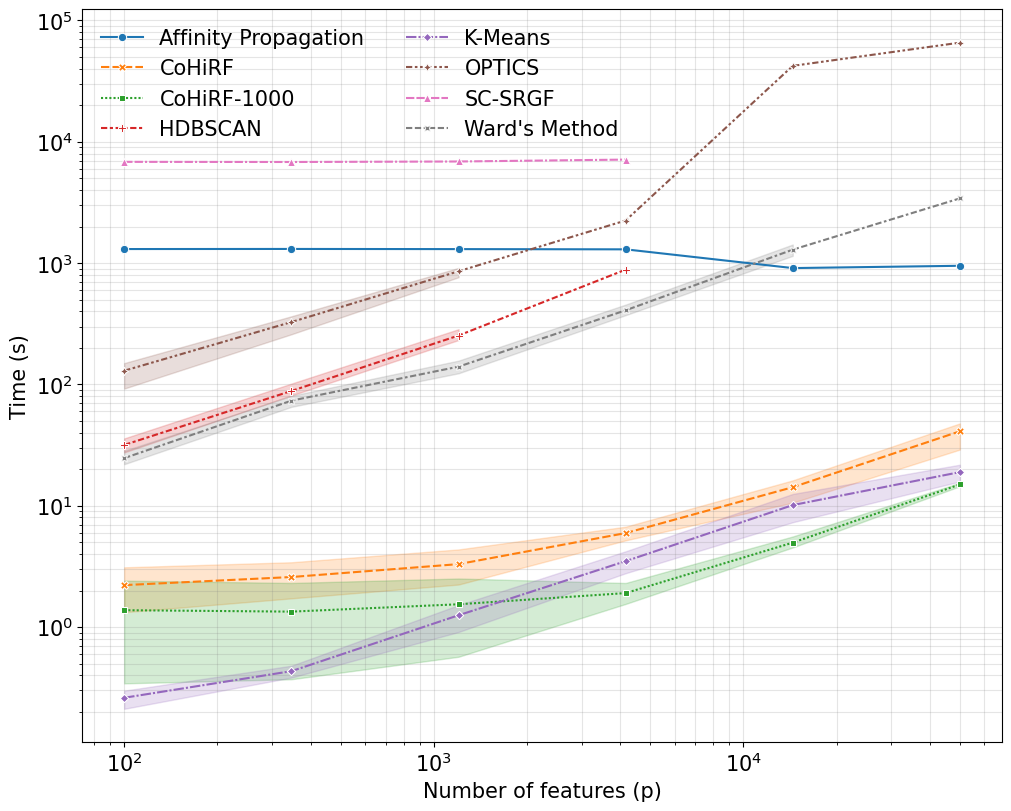

In [256]:
df = df_runs.copy()
df['n_samples'] = df['n_samples'].astype(int)
df['n_features'] = df['n_features'].astype(int)
n_features = 14427
n_samples = 14427
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.loc[df['model_nickname'].isin(['RecursiveClustering','RecursiveClustering_aproximated', 'KMeans', 'HDBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by='model_nickname')
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples (n)', 'n_features': 'Number of features (p)', 'model_nickname': 'Model'})
plt.style.use('default')
# plt.style.use('seaborn-v0_8-paper')
with mpl.rc_context(rc={
    'figure.constrained_layout.use': True, 
    'savefig.bbox': 'tight', 
    'figure.figsize': (10, 8),
    'legend.loc': 'upper left',
    'legend.frameon': False,
    'font.size': 15,
    # 'font.family': 'serif',
    # 'font.serif': 'Times',
    'text.color': 'black',
    'grid.color': 'black',
    'grid.alpha': 0.5,
}):
    # fig, axs = plt.subplots(1, 1)
    # axs = axs.flatten()
    df_plot = df.copy()
    # df_plot = df_plot.loc[df_plot['Number of features (p)']==n_features]
    df_plot = df_plot.loc[df_plot['Number of samples (n)']==n_samples]
    ax = sns.lineplot(data=df_plot, x='Number of features (p)', y='Time (s)', hue='Model', style='Model', markers=True, errorbar='ci')
    ax.set_xscale('log')
    ax.set_yscale('log')
    # set grid
    ax.grid(True, which='both', color='gray', alpha=0.2)
    plt.legend(title=None, bbox_to_anchor=(0.0, 1.0), ncols=2)
    plt.savefig(f'time_n-features_n-samples{n_samples}_2.pdf')
        # plt.legend(title=None, bbox_to_anchor=(0.6, 0.3))
        # plt.savefig(f'hypercube_n-samples{n_samples}_n-features{n_features}_pct-random{pct_random}.pdf')
        # plt.show()
    plt.show()

In [233]:
df_plot

,status,start_time,end_time,Model,model_params/representative_method,n_cores,Number of features,n_jobs,Number of samples,seed_dataset,Time (s),Memory (MB),EXCEPTION,raised_exception
daeba1b976834f988bbaa55a26b43b07,FINISHED,1.733315e+12,1.733316e+12,Affinity Propagation,NaN,4,50000,NaN,14427,0,950.120544,15093.744,NaN,False
da949e442502476bb21ae9dac6aff949,FINISHED,1.738253e+12,1.738254e+12,Affinity Propagation,NaN,4,14427,NaN,14427,2,970.724413,10611.408,NaN,False
2dfce60c2393401c8cb60f8d8e1c69d6,FINISHED,1.733243e+12,1.733244e+12,Affinity Propagation,NaN,4,1202,NaN,14427,0,1303.966123,8041.264,NaN,False
76c66781187843f5b8da0e18e37d88ba,FINISHED,1.733243e+12,1.733244e+12,Affinity Propagation,NaN,4,100,NaN,14427,0,1305.449661,10063.452,NaN,False
cab9d8de96794bd4933b81d74ff791cd,FINISHED,1.733315e+12,1.733316e+12,Affinity Propagation,NaN,4,14427,NaN,14427,0,844.338348,10614.240,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4e0b96330c514159a9ee69c57aff0f2a,FINISHED,1.738251e+12,1.738251e+12,Ward's Method,NaN,4,100,NaN,14427,4,21.183220,2026.516,NaN,False
51384fd5e1cc47449f8866d5bc79854f,FINISHED,1.733321e+12,1.733321e+12,Ward's Method,NaN,4,4163,NaN,14427,0,422.569989,2377.932,NaN,False
572e4d14a5ab483a8375cf27f3cf2c61,FINISHED,1.733321e+12,1.733321e+12,Ward's Method,NaN,4,1202,NaN,14427,0,130.313048,2050.272,NaN,False
e52e382e377040faa7771e68da3edf3f,FINISHED,1.738251e+12,1.738253e+12,Ward's Method,NaN,4,14427,NaN,14427,2,1439.519601,4082.652,NaN,False


In [ ]:
df = df_common.copy()
n_features = 14427
df = df.loc[df['n_features']==n_features]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'RecursiveClustering_aproximated', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_rbf': 'CoHiRF-RBF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by=['model_nickname', 'n_samples'])
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model'})
fig = px.line(df, x='Number of samples', y='Time (s)', color='Model', line_dash='Model', log_x=True, log_y=True, markers=True, template='presentation', 
              category_orders={'Model': ['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering']})
# # transparent background
fig.update_layout({
    'font': {
        'color': 'black',
        'size': 15
    },
    'xaxis': {
        'color': 'black',
        'title': {'standoff': 15},
    }, 
    'yaxis': {
        'color': 'black',
    },
    'margin': {
        't': 10,
        'b': 50,
        'l': 50,
        'r': 30,
    },
    'legend': {
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': 1.02,
        'xanchor': 'left',
        'x': 0.01,
        'title': {'text': ''}
    }
})
fig.update_xaxes(showline=True, mirror=True, dtick='D2')
fig.update_yaxes(showline=True, mirror=True, dtick='D2')
fig.show()
fig.write_image(f'time_n-samples_n-features{n_features}.pdf')

# Get common combinations

In [83]:
df_runs_raw['model_nickname'].unique().tolist()

['RecursiveClustering',
 'KMeans',
 'Proclus',
 'AffinityPropagation',
 'Clique',
 'SpectralClustering',
 'HDBSCAN',
 'MeanShift',
 'SingleAgglomerativeClustering',
 'IRFLLRR',
 'CompleteAgglomerativeClustering',
 'KMeansProj',
 'DBSCAN',
 'OPTICS',
 'SpectralSubspaceRandomization',
 'AverageAgglomerativeClustering',
 'WardAgglomerativeClustering']

In [84]:
model_nickname = [
    'RecursiveClustering',
    'RecursiveClustering_aproximated',
    'KMeans',
    'Proclus',
    'AffinityPropagation',
    'Clique',
    'SpectralClustering',
    'HDBSCAN',
    'MeanShift',
    'SingleAgglomerativeClustering',
    'IRFLLRR',
    'CompleteAgglomerativeClustering',
    'KMeansProj',
    'DBSCAN',
    'OPTICS',
    'SpectralSubspaceRandomization',
    'AverageAgglomerativeClustering',
    'WardAgglomerativeClustering'
]
df = df_runs.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
column = 'model_nickname'
combination_columns = ['n_samples', 'n_features']
common_combinations = get_common_combinations(df, column, combination_columns)

In [85]:
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [86]:
df_common['n_samples'] = df_common['n_samples'].astype(int)
df_common['n_features'] = df_common['n_features'].astype(int)

In [87]:
df_common

,status,start_time,end_time,model_nickname,model_params/representative_method,n_cores,n_features,n_jobs,n_samples,fit_model_return_elapsed_time,max_memory_used,EXCEPTION,raised_exception
00069f9700f1440a9dd1c3e85a51c153,FINISHED,1.732899e+12,1.732899e+12,RecursiveClustering,closest_overall,1,14427,1,100,0.108414,278.552,NaN,False
002ae3bc028c4dd6be9a023079ad331e,FINISHED,1.738204e+12,1.738204e+12,RecursiveClustering_aproximated,closest_overall_1000,4,14427,4,347,0.348808,348.192,NaN,False
01144a4db4ec4f3eacec84b883262710,FINISHED,1.732902e+12,1.732902e+12,KMeans,NaN,1,4163,NaN,50000,7.079966,39404.500,NaN,False
01e9b7f4d4a242fea08ef947f475d150,FINISHED,1.733235e+12,1.733235e+12,AffinityPropagation,NaN,4,347,NaN,347,0.429152,419.316,NaN,False
02a83aa346bf423c80077788a889a0d4,FINISHED,1.733067e+12,1.733067e+12,Clique,NaN,1,14427,NaN,50000,359.365488,39392.436,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SpectralSubspaceRandomization_50000_100,FAILED,1.738236e+12,1.738236e+12,SpectralSubspaceRandomization,NaN,NaN,100,NaN,50000,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_347,FAILED,1.738236e+12,1.738236e+12,SpectralSubspaceRandomization,NaN,NaN,347,NaN,50000,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_1202,FAILED,1.738236e+12,1.738236e+12,SpectralSubspaceRandomization,NaN,NaN,1202,NaN,50000,inf,inf,NoRun,True
SpectralSubspaceRandomization_50000_4163,FAILED,1.738236e+12,1.738236e+12,SpectralSubspaceRandomization,NaN,NaN,4163,NaN,50000,inf,inf,NoRun,True


# Plots

## Time

In [33]:
df_time = df_common.copy()
fig = px.box(df_time, x='model_nickname', y='fit_model_return_elapsed_time', color='model_nickname', log_y=True)
fig.show()

In [ ]:
n_samples = ['100', '347', '1202', '4163', '14427', '50000']

In [39]:
df = df_common.copy()
df = df.loc[df['n_samples']==14427]
df = df.sort_values(by='n_features')
fig = px.line(df, x='n_features', y='fit_model_return_elapsed_time', color='model_nickname', line_dash='model_nickname', log_x=True, log_y=True, markers=True)
fig.show()

In [92]:
df = df_common.copy()
n_features = 14427
df = df.loc[df['n_features']==n_features]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'RecursiveClustering_aproximated', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_rbf': 'CoHiRF-RBF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by=['model_nickname', 'n_samples'])
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model'})
fig = px.line(df, x='Number of samples', y='Time (s)', color='Model', line_dash='Model', log_x=True, log_y=True, markers=True, template='presentation', 
              category_orders={'Model': ['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering']})
# # transparent background
fig.update_layout({
    'font': {
        'color': 'black',
        'size': 15
    },
    'xaxis': {
        'color': 'black',
        'title': {'standoff': 15},
    }, 
    'yaxis': {
        'color': 'black',
    },
    'margin': {
        't': 10,
        'b': 50,
        'l': 50,
        'r': 30,
    },
    'legend': {
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': 1.02,
        'xanchor': 'left',
        'x': 0.01,
        'title': {'text': ''}
    }
})
fig.update_xaxes(showline=True, mirror=True, dtick='D2')
fig.update_yaxes(showline=True, mirror=True, dtick='D2')
fig.show()
fig.write_image(f'time_n-samples_n-features{n_features}.pdf')

In [93]:
df = df_common.copy()
n_samples = 14427
df = df.loc[df['n_samples']==n_samples]
df = df.loc[df['model_nickname'].isin(['RecursiveClustering', 'RecursiveClustering_aproximated', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering'])]
models_names = {
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_rbf': 'CoHiRF-RBF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df.sort_values(by=['model_nickname', 'n_features'])
df = df.rename(columns={'fit_model_return_elapsed_time': 'Time (s)', 'max_memory_used': 'Memory (MB)', 'n_samples': 'Number of samples', 'n_features': 'Number of features', 'model_nickname': 'Model'})
fig = px.line(df, x='Number of features', y='Time (s)', color='Model', line_dash='Model', log_x=True, log_y=True, markers=True, template='presentation',
              category_orders={'Model': ['RecursiveClustering', 'KMeans', 'HDBSCAN', 'DBSCAN', 'AffinityPropagation', 'OPTICS', 'SpectralSubspaceRandomization', 'WardAgglomerativeClustering']})
# # transparent background
fig.update_layout({
    'font': {
        'color': 'black',
        'size': 15
    },
    'xaxis': {
        'color': 'black',
        'title': {'standoff': 15},
    }, 
    'yaxis': {
        'color': 'black',
    },
    'margin': {
        't': 10,
        'b': 50,
        'l': 50,
        'r': 30,
    },
    'legend': {
        'orientation': 'h',
        'yanchor': 'bottom',
        'y': 1.02,
        'xanchor': 'left',
        'x': 0.01,
        'title': {'text': ''}
    }
})
fig.update_xaxes(showline=True, mirror=True, dtick='D2')
fig.update_yaxes(showline=True, mirror=True, dtick='D2')
fig.show()
fig.write_image(f'time_n-features_n-samples{n_samples}.pdf')

## Memory

In [58]:
df = df_common.copy()
df = df.loc[df['n_features']==14427]
df = df.sort_values(by='n_samples')
fig = px.line(df, x='n_samples', y='max_memory_used', color='model_nickname', line_dash='model_nickname', log_x=True, log_y=True, markers=True)
fig.show()

In [59]:
df = df_common.copy()
df = df.loc[df['n_samples']==14427]
df = df.sort_values(by='n_features')
fig = px.line(df, x='n_features', y='max_memory_used', color='model_nickname', line_dash='model_nickname', log_x=True, log_y=True, markers=True)
fig.show()

# Debug and explore

In [45]:
df_runs_raw[columns_names].duplicated().any()

False

In [36]:
df_to_delete = df_runs_raw.loc[df_runs_raw.test_logloss.isna()]

In [37]:
df_to_delete

key,status,start_time,end_time,dataset_name,model_name,model_nickname,seed_model,task_fold,task_id,task_name,test_auc,test_logloss,duration
run_uuid,,,,,,,,,,,,,
03cab7b441e34b40bd8ad8dc60fcd836,FINISHED,1726540996777,1726578901049,insurance_company,Transformer,TabBenchmarkTransformer,0,7,362081,binary_classification,NaN,NaN,10.528964
049febc2449c46c3afdd56d2afcaff5c,FINISHED,1726551253408,1726578901052,GesturePhaseSegmentationProcessed,Transformer,TabBenchmarkTransformer,0,4,14969,classification,NaN,NaN,7.679901
04abe372bcd84f2eadaea736307038f8,FINISHED,1726579962480,1726586658278,credit,Transformer,TabBenchmarkTransformer,0,6,361055,binary_classification,NaN,NaN,1.859944
05539e85c0604675b3f93096e8bc1feb,FINISHED,1726270121868,1726270157619,kc1,Transformer,TabBenchmarkTransformer,0,7,3917,binary_classification,NaN,NaN,0.009931
0e5ef3a920bf49869074fe5950bff043,FINISHED,1726579689874,1726586658276,artificial-characters,Transformer,TabBenchmarkTransformer,0,4,14964,classification,NaN,NaN,1.935667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f1f2c35f12104ead8b8f7e6e320c92d4,FINISHED,1726458758738,1726458823282,magic,Transformer,TabBenchmarkTransformer,0,4,146206,binary_classification,NaN,NaN,0.017929
f26f36657d21499280e65e2581921373,FINISHED,1726573970041,1726578901053,pendigits,Transformer,TabBenchmarkTransformer,0,2,32,classification,NaN,NaN,1.369726
f2def598dec344d5a4e82e1a5510e4bc,FINISHED,1726583892918,1726586658286,Pulsar-Dataset-HTRU2,Transformer,TabBenchmarkTransformer,0,5,362099,binary_classification,NaN,NaN,0.768158


In [38]:
run_uuid_query = [f"'{run_id}'" for run_id in df_to_delete.index]
run_uuid_query = ', '.join(run_uuid_query)

In [39]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    